In [1]:
import os

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path)

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover, BallCover, KNNCover, TrivialCover
from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic
from tdamapper.clustering import FailSafeClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc

from functions import *

from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("./Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("./Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1_new.csv")[:-2]

In [3]:
dataA2[dataA2['當事者順位'] == 1].shape

(189216, 51)

In [4]:
dataA1[dataA1['當事者順位'] == 1].shape

(787, 51)

In [10]:
select_lst = [
    '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者',
    '道路型態大類別名稱', '事故位置大類別名稱',  '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    # '路面狀況-路面狀態名稱',
    '死亡受傷人數', '經度', '緯度',
]

In [7]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False).sample(sample).reset_index(drop=True)
    sample_data = sample_data[sample_data['發生月份'] < 7]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

def get_full_info(mapper_plot):
    x = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
    y = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
    z = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

    threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

    import re
    data_tuple = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

    data = []
    for item in data_tuple:
        color = int(re.search(r'color: (-?\d+)', item).group(1))
        node = int(re.search(r'node: (\d+)', item).group(1))
        size = int(re.search(r'size: (\d+)', item).group(1))
        data.append({'color': color, 'node': node, 'size': size})
    component_info = pd.DataFrame(data)

    full_info = pd.concat([component_info, threeDimData], axis=1)

    mp_content_origin = vars(mapper_plot._MapperLayoutInteractive__graph)['_node']

    mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
    mp_content.reset_index(inplace=True)
    mp_content.rename(columns={'index': 'node'}, inplace=True)

    full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')
    full_info.iloc[:, 3:6]
    
    return full_info

def resample_plot(A1, A2, selected, p_age = False):
    dist_dfA1 = preprocess(dataA1, selected, sample = 50)
    dist_dfA2 = preprocess(dataA2, selected, sample = 5000)

    rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)
    
    rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
    rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
    if p_age == True:
        rbind_data = process_age(rbind_data)

    dist_df = process_data(rbind_data)
    scaler = StandardScaler()

    full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
    X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1).to_numpy()

    lens1 = PCA(10).fit_transform(X1)

    mapper_algo1 = MapperAlgorithm(
        cover = CubicalCover(
            n_intervals = 3,
            overlap_frac = 0.5
        ),
        clustering = FailSafeClustering(
            clustering = AgglomerativeClustering(3, linkage='ward'),
            verbose = False)
    )
    mapper_graph1 = mapper_algo1.fit_transform(X1, lens1)

    mapper_plot1 = MapperLayoutInteractive(
        mapper_graph1,
        colors = dist_df[['路面狀況-路面狀態名稱']].to_numpy(),
        cmap = 'jet',
        # agg = np.nanmean,
        agg = most_frequent_nonan,
        dim = 3,
        iterations = 30,
        seed = 6,
        width = 300,
        height = 300)
    
    return mapper_plot1

In [5]:
def get_calinski_from_db(input_data, eps):
    X = input_data.iloc[:, 3:6]

    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    input_data['label'] = labels
    # Cluster大於1才會計算
    if n_clusters_ > 1:
        filtered_labels = labels[labels != -1]
        filtered_X = X[labels != -1]
        score = calinski_harabasz_score(filtered_X, filtered_labels)
        silhouette_score_value = silhouette_score(filtered_X, filtered_labels)
    else:
        score = -1
        silhouette_score_value = -1
        
    return score, input_data, db, labels, n_clusters_, silhouette_score_value

In [9]:
mapper_plot1 = resample_plot(dataA1, dataA2, select_lst)
# full_info = get_full_info(mapper_plot1)
# calinski_data = get_calinski_from_db(full_info, 0.1)
# print(calinski_data[0])

# labels = calinski_data[3]
# db = calinski_data[2]
# n_clusters_ = calinski_data[4]

print(n_clusters_)

fig_mean1 = mapper_plot1.plot()
fig_mean1.show(config={'scrollZoom': True})

1345.5258399676507
2


In [45]:
calinski_lst = []
cluster_lst = []
silhouette_lst = []

import time

start_time = time.time()
for i in range(100):
    if i%10 == 0:
        print(i)
    
    mapper_plot1 = resample_plot(dataA1, dataA2, select_lst)
    full_info = get_full_info(mapper_plot1)
    calinski_data = get_calinski_from_db(full_info, 0.1)
    
    calinski_lst.append(calinski_data[0])
    cluster_lst.append(calinski_data[4])
    silhouette_lst.append(calinski_data[5])
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time)

0
10
20
30
40
50
60
70
80
90
Execution Time: 837.8088450431824


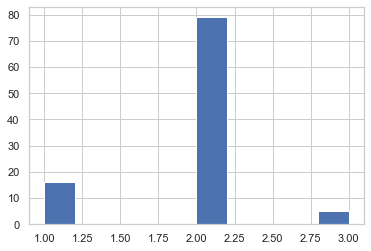

In [46]:
plt.hist(cluster_lst, bins=10)
plt.show()

In [47]:
from collections import Counter
count = Counter(cluster_lst)

# 計算總數
total = len(cluster_lst)

# 打印每個元素的百分比
for key in sorted(count):
    percent = (count[key] / total) * 100
    print(f"Cluster {key}: {percent:.2f}%")

Cluster 1: 16.00%
Cluster 2: 79.00%
Cluster 3: 5.00%


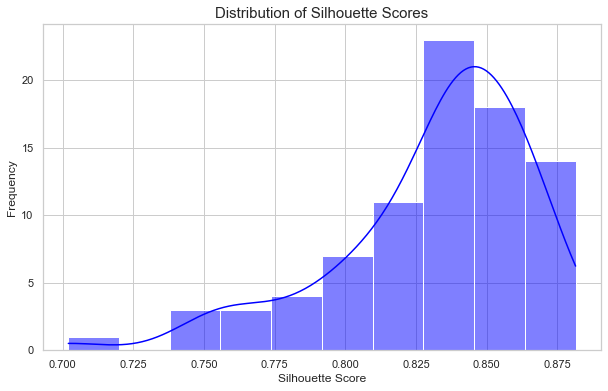

In [105]:
filtered_silhouettes = [x for x in silhouette_lst if x > 0]
# filtered_silhouettes = [x for x in filtered_silhouettes if x > 0.2]

import matplotlib.pyplot as plt
import seaborn as sns
# plt.hist(silhouette_lst, bins=30)
# plt.show()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(filtered_silhouettes, bins=10, kde=True, color="blue")

# 添加標題和標籤
plt.title("Distribution of Silhouette Scores", fontsize=15)
plt.xlabel("Silhouette Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# 顯示圖表
plt.show()

In [78]:
import statistics
mean_score = statistics.mean(filtered_silhouettes)
stdev_score = statistics.stdev(filtered_silhouettes)

print(f"平均值: {mean_score}")
print(f"標準差: {stdev_score}")

平均值: 0.831331667337032
標準差: 0.034433955589656194


In [70]:
ks_statistic, p_value = stats.kstest(filtered_silhouettes, 'norm', args=(mean_score, stdev_score))
p_value

0.022041608653975326

In [109]:
from scipy.stats import skew, shapiro

# 1. 計算偏度
skewness = skew(filtered_silhouettes)
print(f'數據的偏度: {skewness}')
if skewness < 0:
    print("數據呈現左偏分布")
else:
    print("數據不呈現左偏分布")

數據的偏度: -1.305009978252835
數據呈現左偏分布
